HISTOGRAM

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Soft Computing Resources/AlgX3_64x64_merged_tensors_with_labels.zip'
extract_path = '/content/'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/AlgX3_64x64_merged_tensors_with_labels.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/AlgX3_64x64_merged_tensors_with_labels'
categories = ['0', '1']

# Parameters
img_size = 64
sequence_length = img_size * img_size  # 64 * 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to 1D array
            img_array = img_to_array(img).flatten()  # Flatten to 1D

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 1D CNN (num_samples, sequence_length, num_features)
X = X.reshape((X.shape[0], sequence_length, 1))

# Split the data into training, validation, and test sets (70% train, 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_3', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(1, activation='sigmoid'))

    # Select optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_1d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {val_accuracy:.2f}')

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_1d_model_best.h5')

Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.9224137663841248

Best val_accuracy So Far: 0.9267241358757019
Total elapsed time: 00h 07m 55s
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9273 - loss: 0.2151
Best Validation Accuracy: 0.93
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8998 - loss: 0.2496


Test Accuracy: 0.90
Best Hyperparameters:
filters_1: 32
kernel_size_1: 3
filters_2: 48
kernel_size_2: 3
filters_3: 128
kernel_size_3: 7
dense_units: 96
optimizer: sgd


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       589
           1       0.96      0.88      0.92       571

    accuracy                           0.93      1160
   macro avg       0.93      0.93      0.93      1160
weighted avg       0.93      0.93      0.93      1160

Confusion Matrix:
[[570  19]
 [ 66 505]]


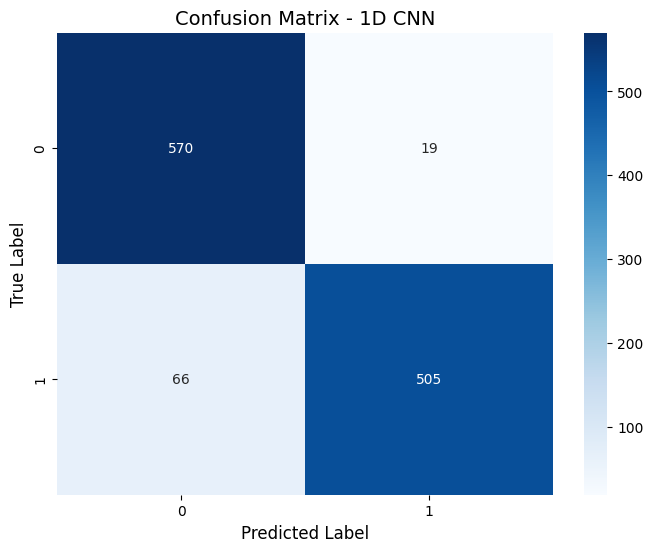

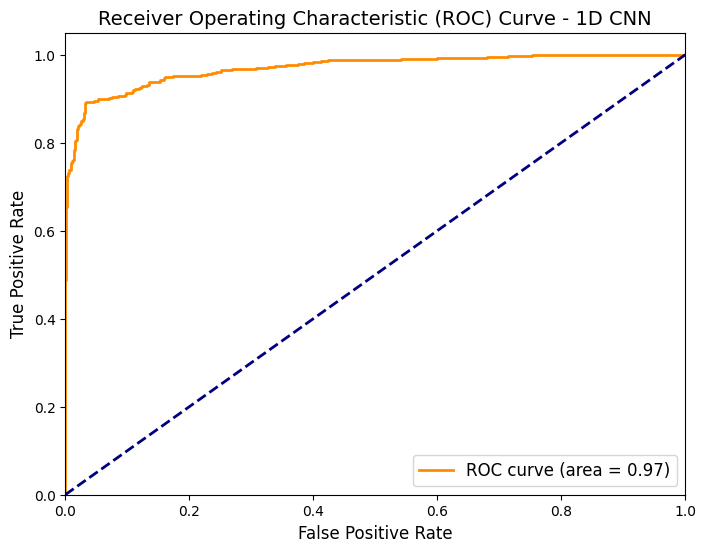

Best Hyperparameters:
filters_1: 32
kernel_size_1: 3
filters_2: 48
kernel_size_2: 3
filters_3: 128
kernel_size_3: 7
dense_units: 96
optimizer: sgd
Best Validation Accuracy: 0.93


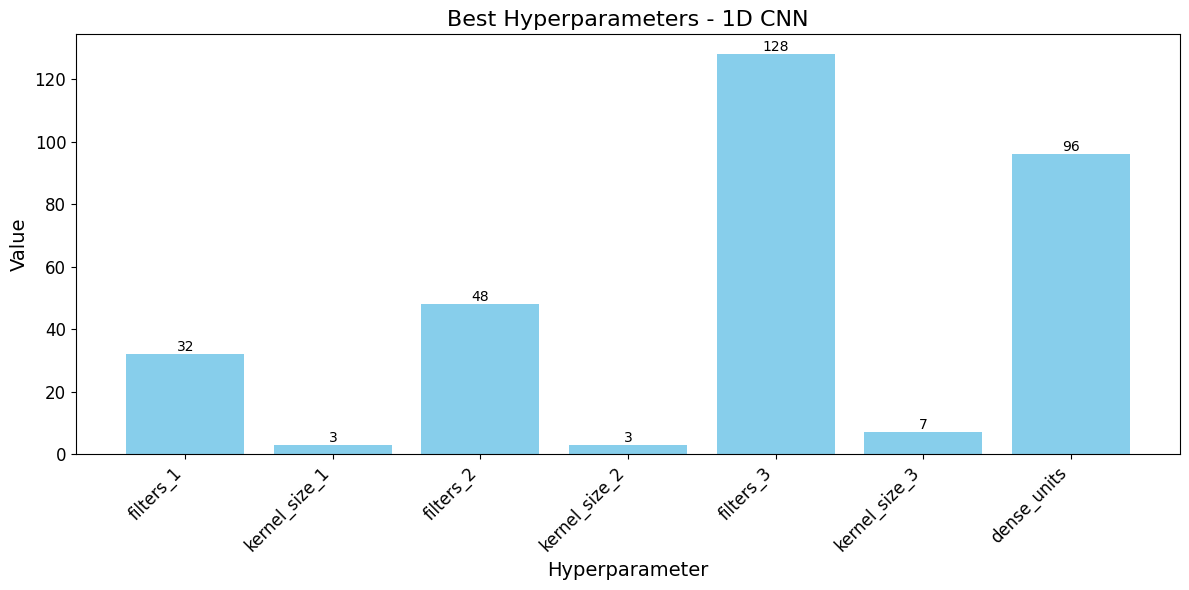

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Generate predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=categories))

# Print Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)  # Print confusion matrix (cf)

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - 1D CNN', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.savefig('/content/confusion_matrix.png')  # Save confusion matrix plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve - 1D CNN', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.savefig('/content/roc_curve.png')  # Save ROC curve plot
plt.show()

# Print the best parameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Print the best validation accuracy
print(f'Best Validation Accuracy: {val_accuracy:.2f}')

# Plot best hyperparameters with increased font sizes
hyperparameters = best_hyperparameters.values
keys = list(hyperparameters.keys())

# Create a list for numeric values and corresponding keys
numeric_keys = []
numeric_values = []

# Populate the lists based on value type
for key in keys:
    value = hyperparameters[key]
    if isinstance(value, int) or isinstance(value, float):  # Check for numeric types
        numeric_keys.append(key)
        numeric_values.append(value)

plt.figure(figsize=(12, 6))
bars = plt.bar(numeric_keys, numeric_values, color='skyblue')

# Adding value annotations on the bars with increased font size
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', ha='center', va='bottom', fontsize=10)

# Set axis labels and title with increased font size
plt.xlabel('Hyperparameter', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Best Hyperparameters - 1D CNN', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('/content/best_hyperparameters.png')  # Save hyperparameters plot
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/AlgX3_64x64_merged_tensors_with_labels'
categories = ['0', '1']

# Parameters
img_size = 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to array
            img_array = img_to_array(img)

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 2D CNN (num_samples, img_size, img_size, 1)
X = X.reshape((X.shape[0], img_size, img_size, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
        activation='relu',
        input_shape=(img_size, img_size, 1)
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_3', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_2d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model for validation set
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_2d_model_best.h5')


Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.9191984534263611

Best val_accuracy So Far: 0.9250161647796631
Total elapsed time: 00h 05m 00s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9184 - loss: 0.2370


Best Validation Accuracy: 0.93
Best Hyperparameters:
filters_1: 96
kernel_size_1: 3
filters_2: 112
kernel_size_2: 3
filters_3: 80
kernel_size_3: 3
dense_units: 224
dropout_rate: 0.4


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


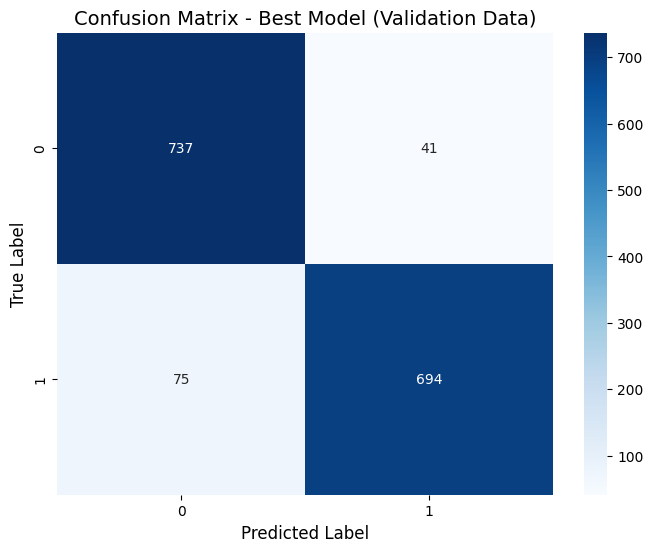

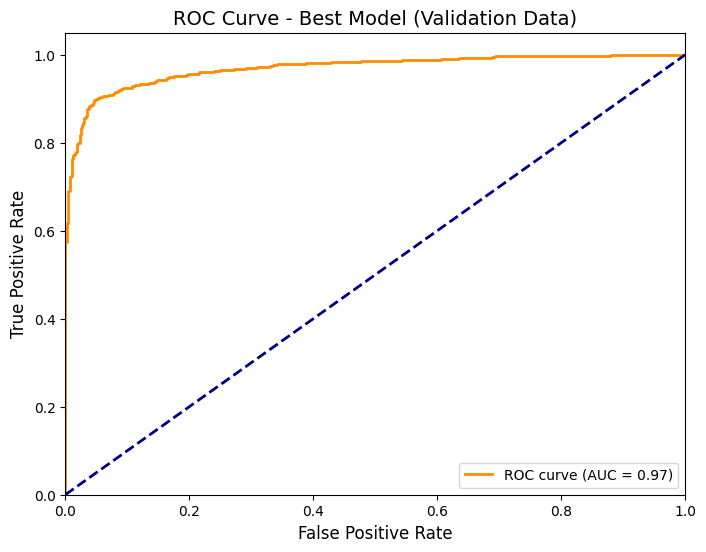

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       778
           1       0.94      0.90      0.92       769

    accuracy                           0.93      1547
   macro avg       0.93      0.92      0.92      1547
weighted avg       0.93      0.93      0.92      1547

Best Hyperparameters:
filters_1: 96
kernel_size_1: 3
filters_2: 112
kernel_size_2: 3
filters_3: 80
kernel_size_3: 3
dense_units: 224
dropout_rate: 0.4


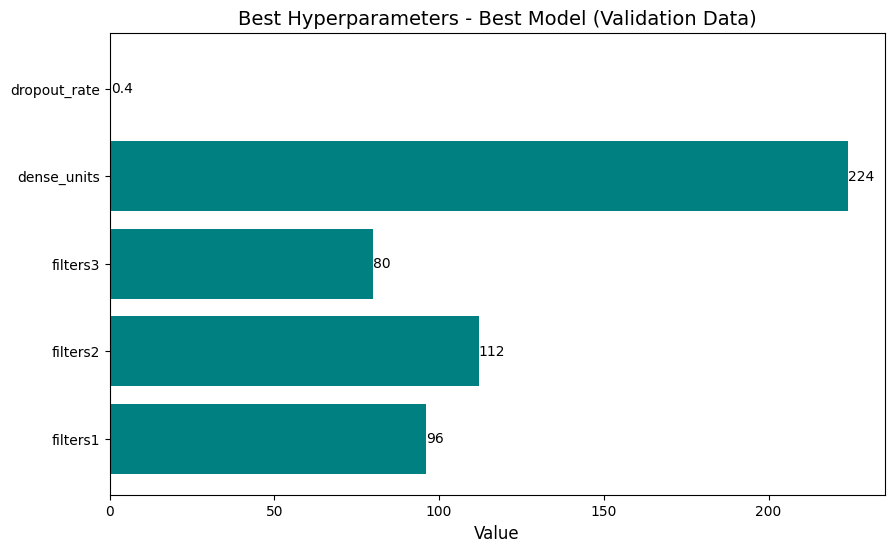

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import load_model

# Load the best model (optional, if not already in memory)
best_model = load_model('/content/cnn_2d_model_best.h5')

# Predict using the best model
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions (0 or 1)
y_pred_probs = y_pred  # Raw probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best Model (Validation Data)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Best Model (Validation Data)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.show()

# Classification Report
class_report = classification_report(y_val, y_pred_classes)
print("Classification Report:")
print(class_report)

# Best Hyperparameters (from Keras Tuner)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]  # Assuming 'tuner' is already defined
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Plot Best Hyperparameters
best_params = {
    'filters1': int(best_hyperparameters['filters_1']),
    'filters2': int(best_hyperparameters['filters_2']),
    'filters3': int(best_hyperparameters['filters_3']),
    'dense_units': int(best_hyperparameters['dense_units']),
    'dropout_rate': best_hyperparameters['dropout_rate']
}

plt.figure(figsize=(10, 6))
params = list(best_params.keys())
values = list(best_params.values())
plt.barh(params, values, color='teal')

# Annotate values on the bar plot
for index, value in enumerate(values):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Value', fontsize=12)
plt.title('Best Hyperparameters - Best Model (Validation Data)', fontsize=14)
plt.show()


HEATMAPS

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Heatmaps/heatmaps.zip'
extract_path = '/content/heatmaps'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/heatmaps.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/heatmaps'
categories = ['0', '1']

# Parameters
img_size = 64
sequence_length = img_size * img_size  # 64 * 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to 1D array
            img_array = img_to_array(img).flatten()  # Flatten to 1D

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 1D CNN (num_samples, sequence_length, num_features)
X = X.reshape((X.shape[0], sequence_length, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_3', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_1d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model for validation set
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_1d_model_best.h5')


Reloading Tuner from bayesian_tuning/cnn_1d/tuner0.json
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9427 - loss: 0.1487


Best Validation Accuracy: 0.94
Best Hyperparameters:
filters_1: 80
kernel_size_1: 5
filters_2: 64
kernel_size_2: 5
filters_3: 96
kernel_size_3: 3
dense_units: 256


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       778
           1       0.96      0.93      0.94       769

    accuracy                           0.94      1547
   macro avg       0.94      0.94      0.94      1547
weighted avg       0.94      0.94      0.94      1547

Confusion Matrix:
[[745  33]
 [ 55 714]]


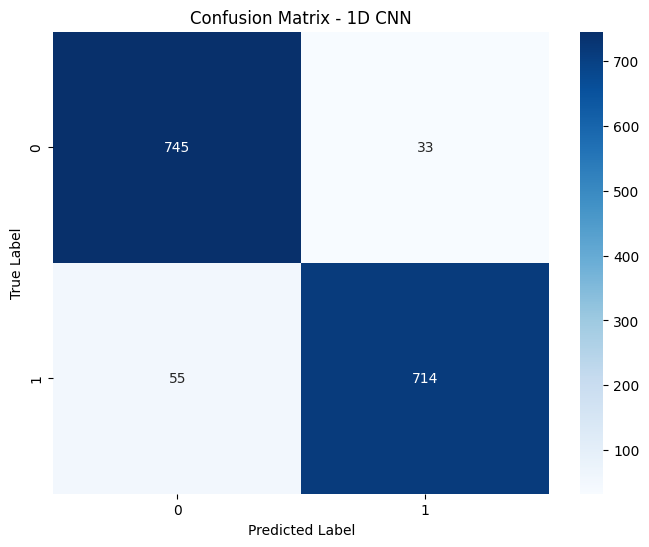

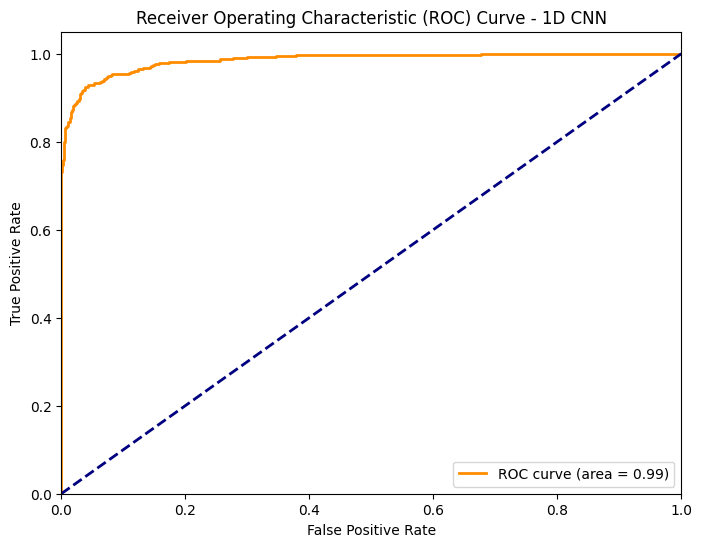

Best Hyperparameters:
filters_1: 80
kernel_size_1: 5
filters_2: 64
kernel_size_2: 5
filters_3: 96
kernel_size_3: 3
dense_units: 256
Best Validation Accuracy: 0.94


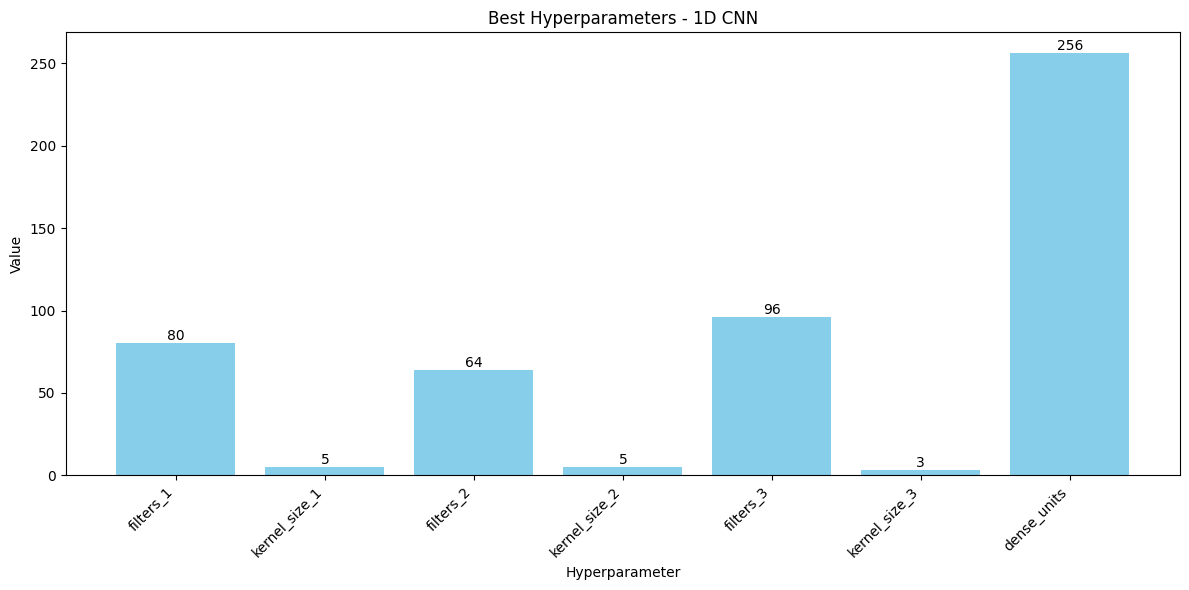

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Generate predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=categories))

# Print Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)  # Print the confusion matrix values

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - 1D CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/confusion_matrix.png')  # Save confusion matrix plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - 1D CNN')
plt.legend(loc='lower right')
plt.savefig('/content/roc_curve.png')  # Save ROC curve plot
plt.show()

# Print the best parameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Print the best validation accuracy
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Plot best hyperparameters with value annotations
hyperparameters = best_hyperparameters.values
keys = list(hyperparameters.keys())
values = [int(value) for value in hyperparameters.values()]  # Convert values to integers

plt.figure(figsize=(12, 6))
bars = plt.bar(keys, values, color='skyblue')

# Adding value annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  # Show as integer

plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Best Hyperparameters - 1D CNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/best_hyperparameters.png')  # Save hyperparameters plot
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/heatmaps'
categories = ['0', '1']

# Parameters
img_size = 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to array
            img_array = img_to_array(img)

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 2D CNN (num_samples, img_size, img_size, 1)
X = X.reshape((X.shape[0], img_size, img_size, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
        activation='relu',
        input_shape=(img_size, img_size, 1)
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_3', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_2d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model for validation set
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_2d_model_best.h5')


Trial 10 Complete [00h 00m 43s]
val_accuracy: 0.9411764740943909

Best val_accuracy So Far: 0.9489334225654602
Total elapsed time: 00h 04m 44s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9581 - loss: 0.1248


Best Validation Accuracy: 0.95
Best Hyperparameters:
filters_1: 48
kernel_size_1: 3
filters_2: 112
kernel_size_2: 5
filters_3: 64
kernel_size_3: 3
dense_units: 160
dropout_rate: 0.4


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


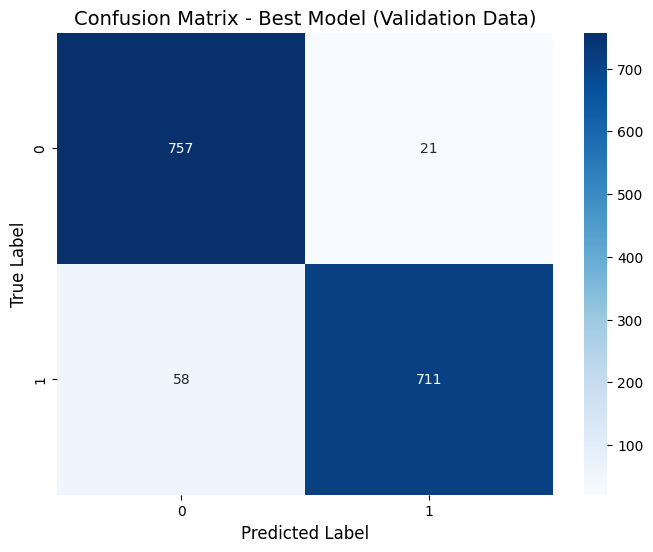

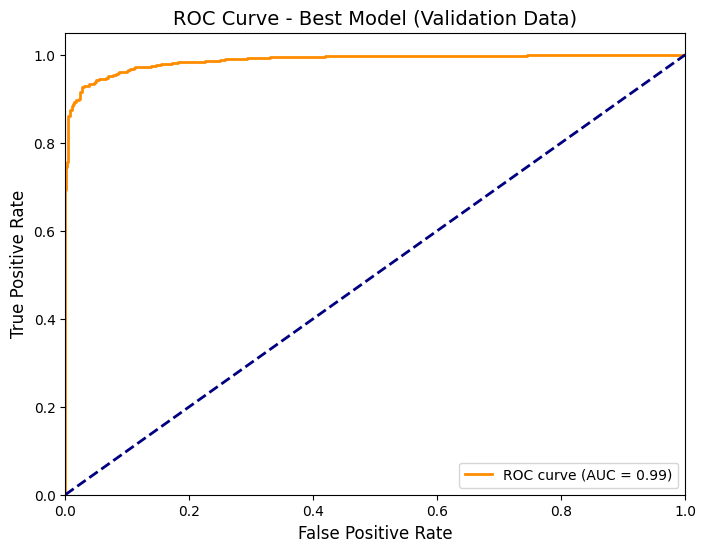

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       778
           1       0.97      0.92      0.95       769

    accuracy                           0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547

Best Hyperparameters:
filters_1: 48
kernel_size_1: 3
filters_2: 112
kernel_size_2: 5
filters_3: 64
kernel_size_3: 3
dense_units: 160
dropout_rate: 0.4


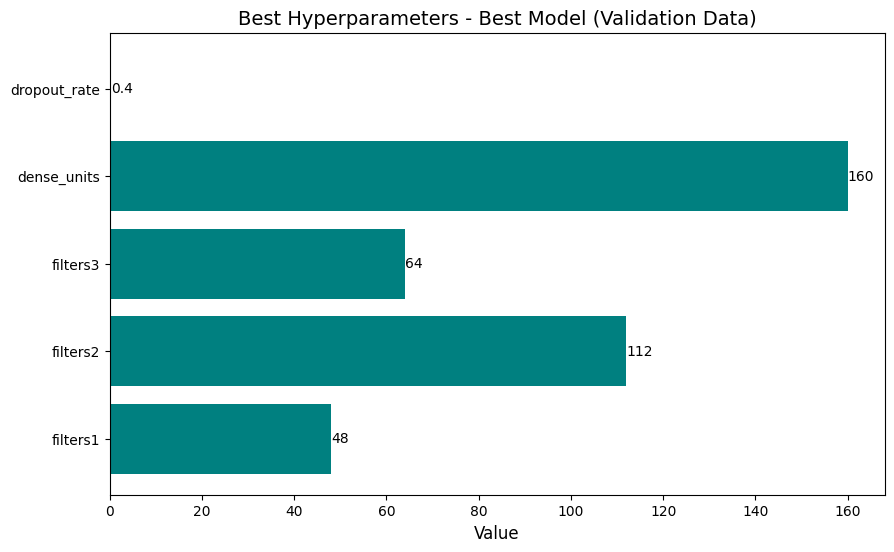

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import load_model

# Load the best model (optional, if not already in memory)
best_model = load_model('/content/cnn_2d_model_best.h5')

# Predict using the best model
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions (0 or 1)
y_pred_probs = y_pred  # Raw probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best Model (Validation Data)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Best Model (Validation Data)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.show()

# Classification Report
class_report = classification_report(y_val, y_pred_classes)
print("Classification Report:")
print(class_report)

# Best Hyperparameters (from Keras Tuner)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]  # Assuming 'tuner' is already defined
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Plot Best Hyperparameters
best_params = {
    'filters1': int(best_hyperparameters['filters_1']),
    'filters2': int(best_hyperparameters['filters_2']),
    'filters3': int(best_hyperparameters['filters_3']),
    'dense_units': int(best_hyperparameters['dense_units']),
    'dropout_rate': best_hyperparameters['dropout_rate']
}

plt.figure(figsize=(10, 6))
params = list(best_params.keys())
values = list(best_params.values())
plt.barh(params, values, color='teal')

# Annotate values on the bar plot
for index, value in enumerate(values):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Value', fontsize=12)
plt.title('Best Hyperparameters - Best Model (Validation Data)', fontsize=14)
plt.show()


BAR GRAPH

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Heatmaps/bargraphs.zip'
extract_path = '/content/bargraphs'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/bargraphs.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/bargraphs'
categories = ['0', '1']

# Parameters
img_size = 64
sequence_length = img_size * img_size  # 64 * 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to 1D array
            img_array = img_to_array(img).flatten()  # Flatten to 1D

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 1D CNN (num_samples, sequence_length, num_features)
X = X.reshape((X.shape[0], sequence_length, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_3', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_1d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_1d_model_best.h5')


Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.8797672986984253

Best val_accuracy So Far: 0.88364577293396
Total elapsed time: 00h 05m 16s
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8924 - loss: 0.3012


Best Validation Accuracy: 0.88
Best Hyperparameters:
filters_1: 32
kernel_size_1: 5
filters_2: 48
kernel_size_2: 3
filters_3: 128
kernel_size_3: 3
dense_units: 192


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       778
           1       0.92      0.84      0.88       769

    accuracy                           0.88      1547
   macro avg       0.89      0.88      0.88      1547
weighted avg       0.89      0.88      0.88      1547

Confusion Matrix:
[[724  54]
 [126 643]]


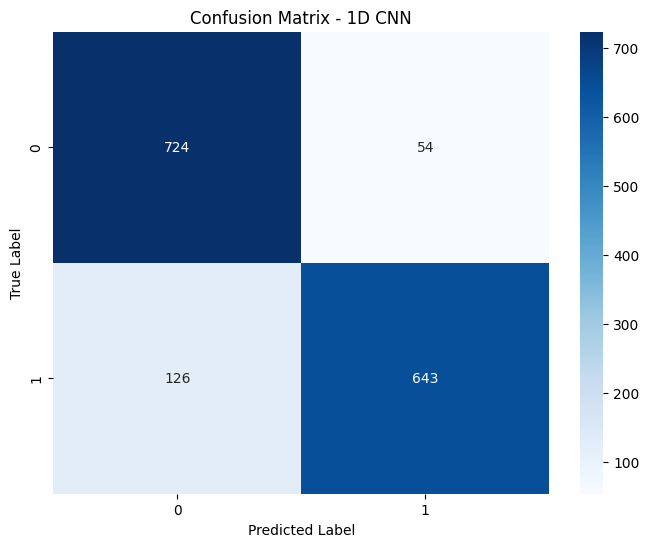

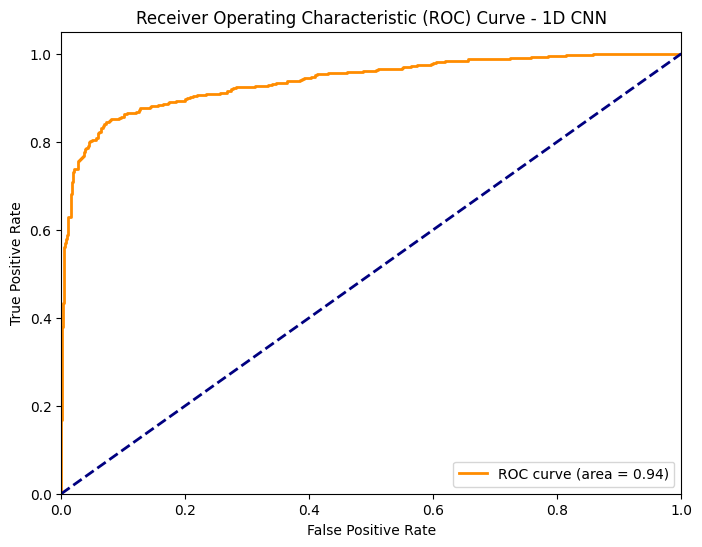

Best Hyperparameters:
filters_1: 32
kernel_size_1: 5
filters_2: 48
kernel_size_2: 3
filters_3: 128
kernel_size_3: 3
dense_units: 192
Best Validation Accuracy: 0.88


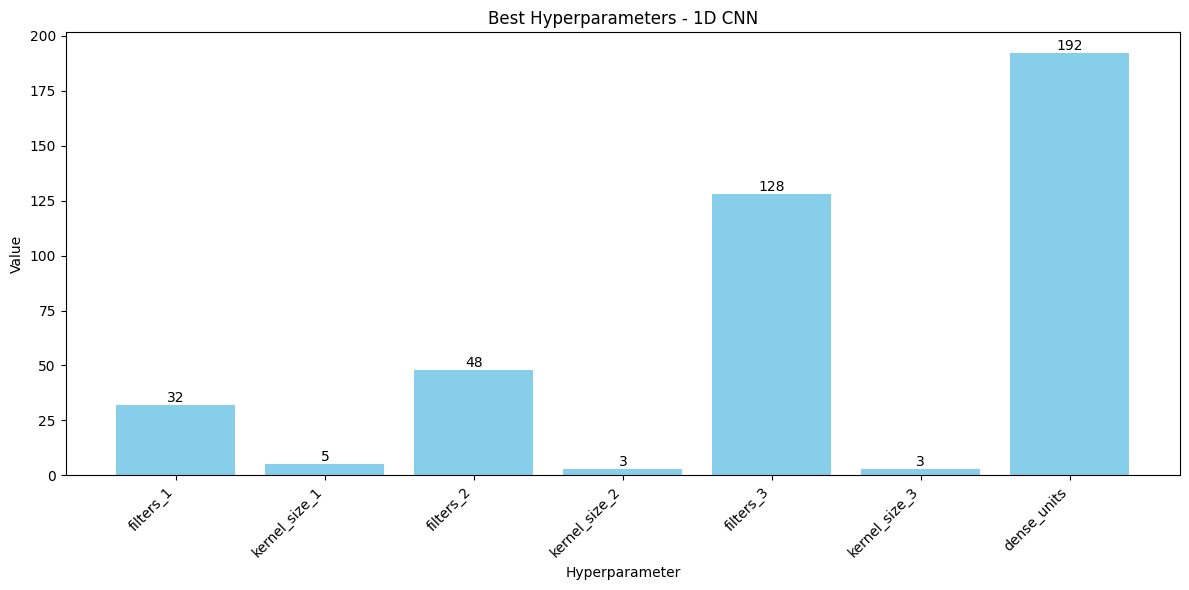

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Generate predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=categories))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")  # Print confusion matrix header
print(conf_matrix)  # Print confusion matrix values

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - 1D CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/confusion_matrix.png')  # Save confusion matrix plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - 1D CNN')
plt.legend(loc='lower right')
plt.savefig('/content/roc_curve.png')  # Save ROC curve plot
plt.show()

# Print the best parameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Print the best validation accuracy
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Plot best hyperparameters with value annotations
hyperparameters = best_hyperparameters.values
keys = list(hyperparameters.keys())
values = [int(value) for value in hyperparameters.values()]  # Convert values to integers

plt.figure(figsize=(12, 6))
bars = plt.bar(keys, values, color='skyblue')

# Adding value annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  # Show as integer

plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Best Hyperparameters - 1D CNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/best_hyperparameters.png')  # Save hyperparameters plot
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/bargraphs'
categories = ['0', '1']

# Parameters
img_size = 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to array
            img_array = img_to_array(img)

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 2D CNN (num_samples, img_size, img_size, 1)
X = X.reshape((X.shape[0], img_size, img_size, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
        activation='relu',
        input_shape=(img_size, img_size, 1)
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_3', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_2d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model for validation set
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_2d_model_best.h5')


Trial 10 Complete [00h 00m 26s]
val_accuracy: 0.8868778347969055

Best val_accuracy So Far: 0.889463484287262
Total elapsed time: 00h 03m 12s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9001 - loss: 0.2883


Best Validation Accuracy: 0.89
Best Hyperparameters:
filters_1: 32
kernel_size_1: 5
filters_2: 96
kernel_size_2: 3
filters_3: 64
kernel_size_3: 7
dense_units: 256
dropout_rate: 0.4


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


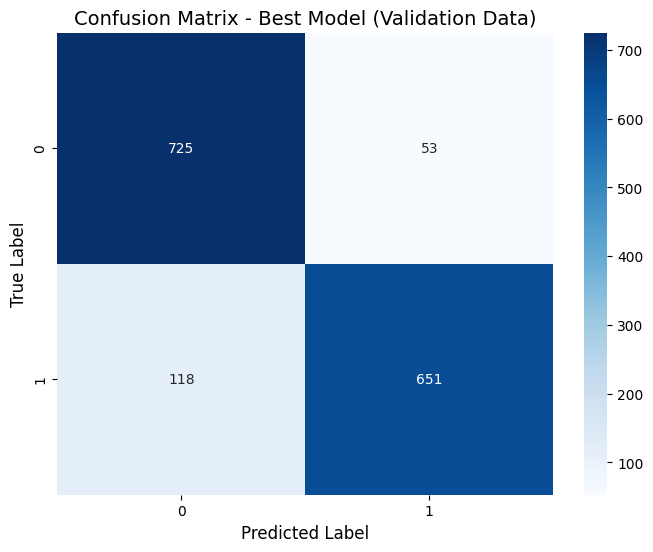

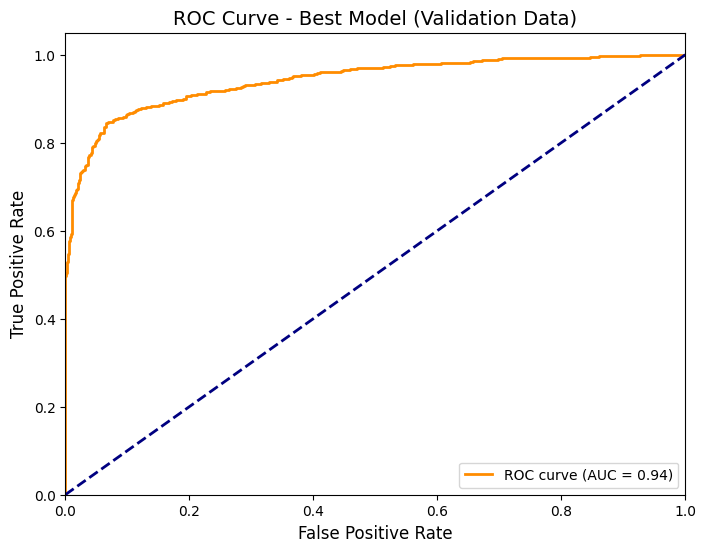

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       778
           1       0.92      0.85      0.88       769

    accuracy                           0.89      1547
   macro avg       0.89      0.89      0.89      1547
weighted avg       0.89      0.89      0.89      1547

Best Hyperparameters:
filters_1: 32
kernel_size_1: 5
filters_2: 96
kernel_size_2: 3
filters_3: 64
kernel_size_3: 7
dense_units: 256
dropout_rate: 0.4


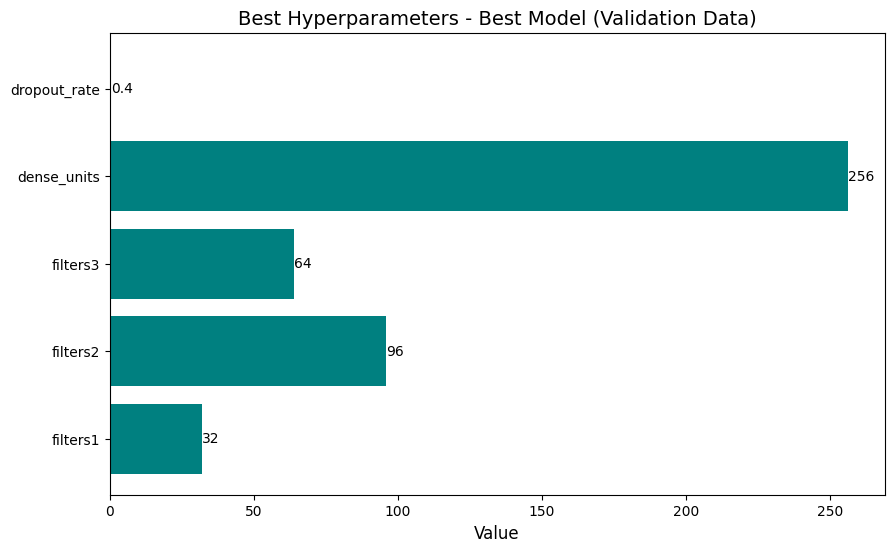

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import load_model

# Load the best model (optional, if not already in memory)
best_model = load_model('/content/cnn_2d_model_best.h5')

# Predict using the best model
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions (0 or 1)
y_pred_probs = y_pred  # Raw probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best Model (Validation Data)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Best Model (Validation Data)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.show()

# Classification Report
class_report = classification_report(y_val, y_pred_classes)
print("Classification Report:")
print(class_report)

# Best Hyperparameters (from Keras Tuner)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]  # Assuming 'tuner' is already defined
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Plot Best Hyperparameters
best_params = {
    'filters1': int(best_hyperparameters['filters_1']),
    'filters2': int(best_hyperparameters['filters_2']),
    'filters3': int(best_hyperparameters['filters_3']),
    'dense_units': int(best_hyperparameters['dense_units']),
    'dropout_rate': best_hyperparameters['dropout_rate']
}

plt.figure(figsize=(10, 6))
params = list(best_params.keys())
values = list(best_params.values())
plt.barh(params, values, color='teal')

# Annotate values on the bar plot
for index, value in enumerate(values):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Value', fontsize=12)
plt.title('Best Hyperparameters - Best Model (Validation Data)', fontsize=14)
plt.show()
